<a href="https://colab.research.google.com/github/NIMADORJEELAMA/Stock-Analysis-/blob/main/stock_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1.Setup & Imports**


In [1]:
# Install yfinance if needed
# !pip install yfinance

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("default")


**2. Download Stock Data**

In [2]:
ticker = "AAPL"  # You can change to MSFT, JPM, TSLA, GS, etc.

df = yf.download(ticker, start="2015-01-01", end="2025-01-01")
df.head()


/tmp/ipython-input-2382422331.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start="2015-01-01", end="2025-01-01")
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2015-01-02,24.237551,24.705320,23.798600,24.694235,212818400
2015-01-05,23.554743,24.086803,23.368523,24.006994,257142000
2015-01-06,23.556955,23.816334,23.195597,23.619029,263188400
2015-01-07,23.887278,23.987038,23.654501,23.765347,160423600
2015-01-08,24.805082,24.862723,24.097885,24.215383,237458000


**3. Technical Indicators**

*SMA 20 & SMA 50*

In [3]:
df['SMA20'] = df['Close'].rolling(20).mean()
df['SMA50'] = df['Close'].rolling(50).mean()


*SMA*

In [4]:
df['EMA20'] = df['Close'].ewm(span=20, adjust=False).mean()


*RSI (14 periods)*

In [5]:
delta = df['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
rs = gain / loss
df['RSI'] = 100 - (100 / (1 + rs))


*MACD*

In [6]:
df['EMA12'] = df['Close'].ewm(span=12, adjust=False).mean()
df['EMA26'] = df['Close'].ewm(span=26, adjust=False).mean()
df['MACD'] = df['EMA12'] - df['EMA26']
df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()


**4. Trading Strategy (SMA Crossover)**


*  BUY when SMA20 > SMA50
*  SELL when SMA20 < SMA50




In [7]:
df['Signal'] = 0
df['Signal'] = np.where(df['SMA20'] > df['SMA50'], 1, 0)
df['Position'] = df['Signal'].diff()


**5. Plot Price + Buy/Sell Signals**

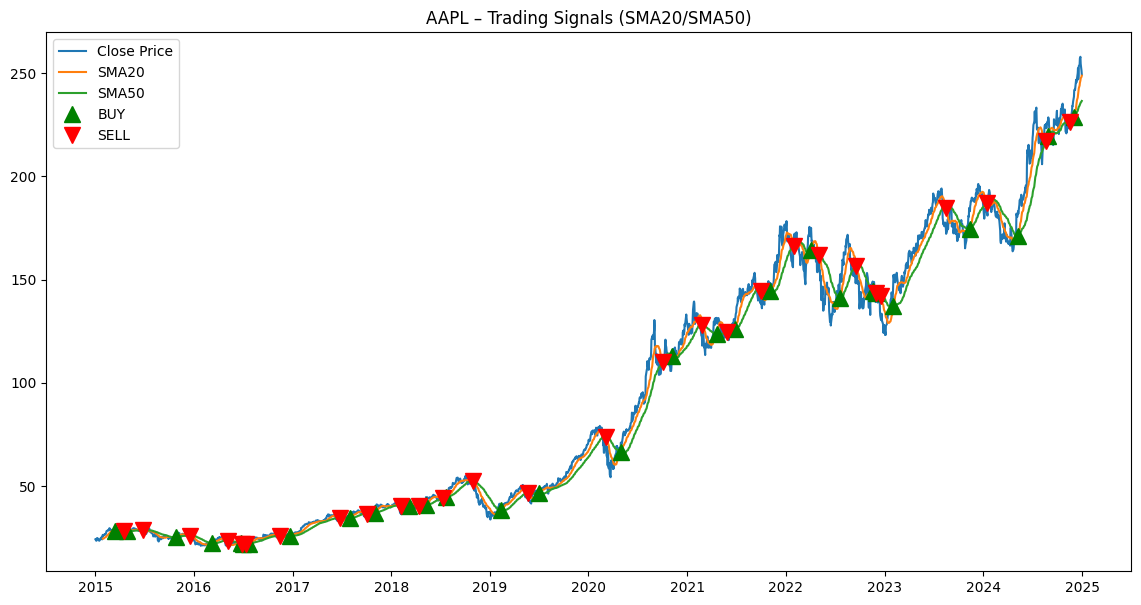

In [8]:
plt.figure(figsize=(14,7))
plt.plot(df['Close'], label='Close Price')
plt.plot(df['SMA20'], label='SMA20')
plt.plot(df['SMA50'], label='SMA50')

# Buy signals
plt.plot(df[df['Position'] == 1].index,
         df['SMA20'][df['Position'] == 1],
         '^', markersize=12, color='green', label='BUY')

# Sell signals
plt.plot(df[df['Position'] == -1].index,
         df['SMA20'][df['Position'] == -1],
         'v', markersize=12, color='red', label='SELL')

plt.title(f"{ticker} – Trading Signals (SMA20/SMA50)")
plt.legend()
plt.show()


**6. Strategy Backtesting**

Returns


In [9]:
df['Market_Return'] = df['Close'].pct_change()
df['Strategy_Return'] = df['Market_Return'] * df['Signal'].shift(1)


Cumulative Returns

In [10]:
df['Cumulative_Market'] = (1 + df['Market_Return']).cumprod()
df['Cumulative_Strategy'] = (1 + df['Strategy_Return']).cumprod()


Plot Comparison


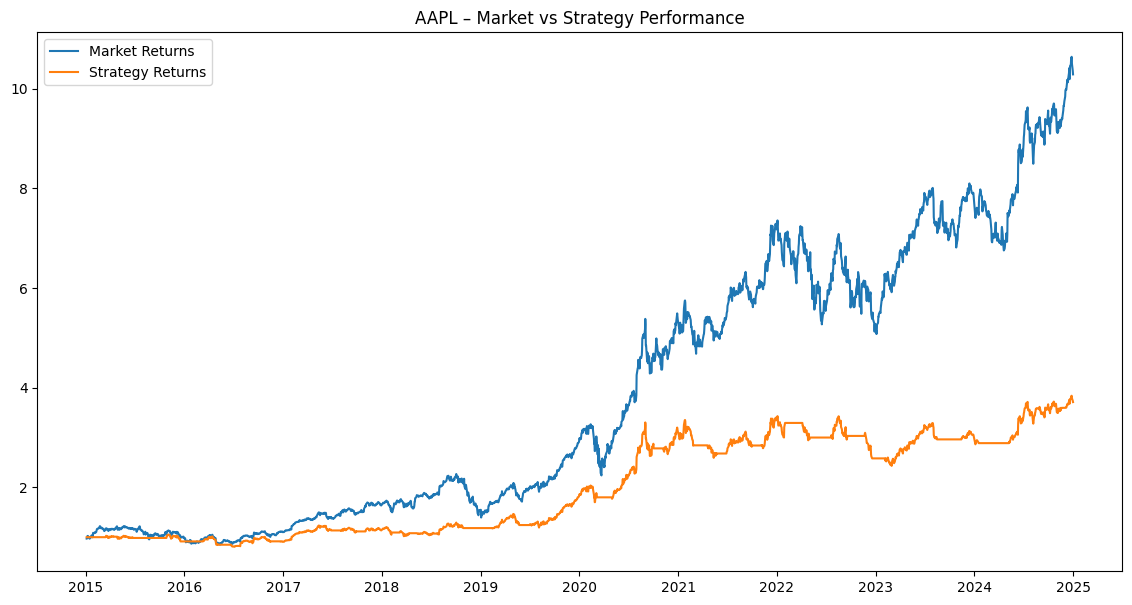

In [11]:
plt.figure(figsize=(14,7))
plt.plot(df['Cumulative_Market'], label='Market Returns')
plt.plot(df['Cumulative_Strategy'], label='Strategy Returns')
plt.title(f"{ticker} – Market vs Strategy Performance")
plt.legend()
plt.show()


**7. Risk Metrics**

Sharpe Ratio

In [12]:
sharpe_ratio = (df['Strategy_Return'].mean() / df['Strategy_Return'].std()) * np.sqrt(252)
sharpe_ratio


np.float64(0.7634986299963494)

Max Drawdown

In [13]:
df['Rolling_Max'] = df['Cumulative_Strategy'].cummax()
df['Drawdown'] = df['Cumulative_Strategy'] / df['Rolling_Max'] - 1
max_drawdown = df['Drawdown'].min()
max_drawdown


-0.2909348728423078

**8. Final Summary**

In [15]:
print("----------- STRATEGY SUMMARY -----------")
print(f"Ticker: {ticker}")
print(f"Sharpe Ratio: {sharpe_ratio:.3f}")
print(f"Max Drawdown: {max_drawdown:.3f}")
print(f"Final Market Return: {df['Cumulative_Market'].iloc[-1]:.2f}x")
print(f"Final Strategy Return: {df['Cumulative_Strategy'].iloc[-1]:.2f}x")


----------- STRATEGY SUMMARY -----------
Ticker: AAPL
Sharpe Ratio: 0.763
Max Drawdown: -0.291
Final Market Return: 10.29x
Final Strategy Return: 3.71x
